In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
from datetime import datetime
import itertools

Loading Price Data

In [2]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(project_root, '..', '..', 'data')

# Summer month
p_summer = pd.read_csv(os.path.join(data_dir, 'Spotmarket_August_Corrected.csv'),sep=',')
#change price from euro/mwh to euro/kwh and renaming the column
p_summer['price_EUR_MWh'] = p_summer['price_EUR_MWh'] / 1000
p_summer.rename(columns={'price_EUR_MWh': 'Spotmarket_(EUR/kWh)'}, inplace=True)

# Winter month
p_winter = pd.read_csv(os.path.join(data_dir, 'Spotmarket_December_Corrected.csv'),sep=',')
#change price from euro/mwh to euro/kwh and renaming the column
p_winter['price_EUR_MWh'] = p_winter['price_EUR_MWh'] / 1000
p_winter.rename(columns={'price_EUR_MWh': 'Spotmarket_(EUR/kWh)'}, inplace=True)

#Spotmarket data from: https://energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=CH&interval=month&year=2024&legendItems=by4&month=12

Loading fixed appliance data

In [3]:
#TV consumption data for summer month
tv_summer = pd.read_csv(os.path.join(data_dir, 'tv_consumption_august_2024_detailed.csv'), sep=',')

#TV consumption data for winter month
tv_winter = pd.read_csv(os.path.join(data_dir, 'tv_consumption_december_2024_detailed.csv'), sep=',')

#Lighting consumption data for summer month
lighting_summer = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_august_2024.csv'), sep=',')

#Lighting consumption data for winter month
lighting_winter = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_december_2024.csv'), sep=',')

#Fridge consumption data for summer month
fridge_summer = pd.read_csv(os.path.join(data_dir, 'fridge_August_Final_Adjusted.csv'), sep=',')

#Fridge consumption data for winter month
fridge_winter = pd.read_csv(os.path.join(data_dir, 'fridge_December_Final_Adjusted.csv'), sep=',')

#Oven consumption data for summer month
oven_summer = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_August_Final.csv'),sep=',')

#Oven consumption data for winter month
oven_winter = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_December_Final.csv'),sep=',')

#Induction stove consumption data for summer month
induction_summer = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_August_Final.csv'),sep=',')

#Induction stove consumption data for winter month
induction_winter = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_December_Final.csv'),sep=',')

#adjust names of columns for summer
p_summer.columns = p_summer.columns.str.replace('price_EUR_MWh', 'Spotmarket_(EUR/kWh)')
tv_summer.columns = tv_summer.columns.str.replace('tv_power_kWh', 'TV_Consumption_(kWh)')
lighting_summer.columns = lighting_summer.columns.str.replace('lighting_power_kWh', 'Lighting_Consumption_(kWh)')
fridge_summer.columns = fridge_summer.columns.str.replace('consumption_kWh', 'Fridges_Consumption_(kWh)')
oven_summer.columns = oven_summer.columns.str.replace('consumption_kWh', 'Oven_Consumption_(kWh)')
induction_summer.columns = induction_summer.columns.str.replace('consumption_kWh', 'Induction_Stove_Consumption_(kWh)')

#adjust names of columns for winter
p_winter.columns = p_winter.columns.str.replace('price_EUR_MWh', 'Spotmarket_(EUR/kWh)')
tv_winter.columns = tv_winter.columns.str.replace('tv_power_kWh', 'TV_Consumption_(kWh)')
lighting_winter.columns = lighting_winter.columns.str.replace('lighting_power_kWh', 'Lighting_Consumption_(kWh)')
fridge_winter.columns = fridge_winter.columns.str.replace('consumption_kWh', 'Fridges_Consumption_(kWh)')
oven_winter.columns = oven_winter.columns.str.replace('consumption_kWh', 'Oven_Consumption_(kWh)')
induction_winter.columns = induction_winter.columns.str.replace('consumption_kWh', 'Induction_Stove_Consumption_(kWh)')

Building Data Base

In [4]:
# Ensure all timestamp columns are of the same type for summer
p_summer['timestamp'] = pd.to_datetime(p_summer['timestamp'])
lighting_summer['timestamp'] = pd.to_datetime(lighting_summer['timestamp'])
fridge_summer['timestamp'] = pd.to_datetime(fridge_summer['timestamp'])
fridge_summer['timestamp'] = fridge_summer['timestamp'] - pd.Timedelta(hours=1)
oven_summer['timestamp'] = pd.to_datetime(oven_summer['timestamp'])
induction_summer['timestamp'] = pd.to_datetime(induction_summer['timestamp'])
tv_summer['timestamp'] = pd.to_datetime(tv_summer['timestamp'])

# Ensure all timestamp columns are of the same type for winter
p_winter['timestamp'] = pd.to_datetime(p_winter['timestamp'])
lighting_winter['timestamp'] = pd.to_datetime(lighting_winter['timestamp'])
fridge_winter['timestamp'] = pd.to_datetime(fridge_winter['timestamp'])
fridge_winter['timestamp'] = fridge_winter['timestamp'] - pd.Timedelta(hours=1)
oven_winter['timestamp'] = pd.to_datetime(oven_winter['timestamp'])
induction_winter['timestamp'] = pd.to_datetime(induction_winter['timestamp'])
induction_winter['timestamp'] = induction_winter['timestamp'].apply(lambda x: x.replace(year=2024))
tv_winter['timestamp'] = pd.to_datetime(tv_winter['timestamp'])

#shorten the dataset to 4 weeks (4 weeks * 7 days * 24 hours = 672 rows) for summer
lighting_summer = lighting_summer.iloc[:4 * 7 * 24]
fridge_summer = fridge_summer.iloc[:4 * 7 * 24]
oven_summer = oven_summer.iloc[:4 * 7 * 24]
induction_summer = induction_summer.iloc[:4 * 7 * 24]
tv_summer = tv_summer.iloc[:4 * 7 * 24]
p_summer = p_summer.iloc[:4 * 7 * 24]

#shorten the dataset to 4 weeks (4 weeks * 7 days * 24 hours = 672 rows) for winter
lighting_winter = lighting_winter.iloc[:4 * 7 * 24]
fridge_winter = fridge_winter.iloc[:4 * 7 * 24]
oven_winter = oven_winter.iloc[:4 * 7 * 24]
induction_winter = induction_winter.iloc[:4 * 7 * 24]
tv_winter = tv_winter.iloc[:4 * 7 * 24]
p_winter = p_winter.iloc[:4 * 7 * 24]

# Merge all datasets on the 'timestamp' column for summer
merged_data_summer = p_summer.merge(lighting_summer, left_on='timestamp', right_on='timestamp', how='outer') \
    .merge(oven_summer, left_on='timestamp', right_on='timestamp', how='outer') \
        .merge(tv_summer, left_on='timestamp', right_on='timestamp', how='inner')\
            .merge(induction_summer, left_on='timestamp', right_on='timestamp', how='inner') \
                .merge(fridge_summer, left_on='timestamp', right_on='timestamp', how='inner') \

#Merge all datasets on the 'timestamp' column for winter
merged_data_winter = p_winter.merge(lighting_winter, left_on='timestamp', right_on='timestamp', how='inner') \
    .merge(oven_winter, left_on='timestamp', right_on='timestamp', how='inner') \
        .merge(tv_winter, left_on='timestamp', right_on='timestamp', how='inner')\
            .merge(induction_winter, left_on='timestamp', right_on='timestamp', how='inner') \
                .merge(fridge_winter, left_on='timestamp', right_on='timestamp', how='inner') \
                    
#Add heat demand for winter
print(len(merged_data_winter['timestamp']))
heat_demand_winter = pd.read_csv(os.path.join(data_dir, 'heating_demand_december.csv'), sep=',')
merged_data_winter['Heating_Demand_(kWh)'] = heat_demand_winter['Hot water + Space Heating demand [kWh]']
# Display the merged dataset
#print(merged_data_summer)
#print(merged_data_winter)

672


## Optimization

### Winter

In [5]:
# Load fixed appliances
price = merged_data_winter["Spotmarket_(EUR/kWh)"].values
fridge = merged_data_winter["Fridges_Consumption_(kWh)"].values
stove = merged_data_winter["Induction_Stove_Consumption_(kWh)"].values
oven = merged_data_winter["Oven_Consumption_(kWh)"].values
tv = merged_data_winter["TV_Consumption_(kWh)"].values
lighting = merged_data_winter["Lighting_Consumption_(kWh)"].values

Time_interval = len(price)  # Total time interval in hours

# Gurobi model
model = gp.Model("automated_demand_response")

Set parameter Username
Set parameter LicenseID to value 2649317
Academic license - for non-commercial use only - expires 2026-04-09


Dishwasher

In [6]:
# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"max_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)- min_gap - duration):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + duration)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")

model.update()

Washing Machine

In [7]:
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if dishwasher is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the washing machine has to run twice per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks-1):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts

for t in range(len(start_times_wm) - min_gap_wm - duration_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + duration_wm)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_winter['Allowed_WM_winter'] = 0 # Initialize with 0

for index, row in merged_data_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_winter.at[index, 'Allowed_WM_winter'] = 1
    else: 
        merged_data_winter.at[index, 'Allowed_WM_winter'] = 0
        
model.addConstrs((binary_wm[t] <= merged_data_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter")

model.update()

Dryer

In [8]:
### including the dryer
# dryer properties
duration_dryer = 2  # hours of operation
max_gap_wm_dryer = 2  # hours between washing machine end and dryer start
power_dryer = 3  # kW during operation -> should be double checked


binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# Binary start variables: 1 if dryer starts at hour t

start_times_dryer = range(Time_interval - duration_dryer + 1)
dryer_start = model.addVars(start_times_dryer, vtype=GRB.BINARY, name="start_dryer")

# Binary on variables: 1 if dryer is on at hour t

binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# When dryer is on, it must be running -> dryer_start is 1 -> binary_dryer at the same time + duration_dryer is 1 

for t, k in itertools.product(range(len(start_times_dryer)), range(duration_dryer)):
    model.addConstr(binary_dryer[t + k] >= dryer_start[t], name=f"dryer_{t}_{k}")

for t in range(len(start_times_dryer)-duration_dryer):
    model.addConstr(gp.quicksum(binary_dryer[t + k] for k in range(duration_dryer+1)) <= duration_dryer, name=f"dryer_max_two_hours_on_{t}")


# Enforce minimum gap of 0 hours and max gap of 2 hours between two end of washing machine and start of dryer



# Enforce that the dryer starts within max_gap_wm_dryer hours after the washing machine ends
for t in range(len(dryer_start)-max_gap_wm_dryer-duration_wm):
    model.addConstr(gp.quicksum(dryer_start[t + offset + duration_wm] for offset in range(0, max_gap_wm_dryer + 1)) >= wm_start[t],
                name=f"max_gap_after_washing_dryer_{t}")



#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
p_summer['Allowed_dryer_summer'] = 0  # Initialize with 0
p_winter['Allowed_dryer_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in p_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        p_summer.at[index, 'Allowed_dryer_summer'] = 1
    else: 
        p_summer.at[index, 'Allowed_dryer_summer'] = 0


for index, row in p_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        p_winter.at[index, 'Allowed_dryer_winter'] = 1
    else: 
        p_winter.at[index, 'Allowed_dryer_winter'] = 0
        
model.addConstrs((binary_dryer[t] <= p_summer['Allowed_dryer_summer'][t] for t in range(len(binary_dryer))), name="allowed_dryer_summer")
#model.addConstrs((binary_wm[t] <= p_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later

model.update()

EV

In [9]:
# Include EV
#EV properties

min_power_ev = 1
max_power_ev = 11

max_capacity_ev = 100

#Variables

soc_ev = model.addVars(Time_interval,lb=0, ub=max_capacity_ev, vtype=GRB.CONTINUOUS, name="soc_ev")

charging_ev = model.addVars(Time_interval,lb=0, ub=max_power_ev, vtype=GRB.CONTINUOUS, name="charging_lvl_ev")

binary_ev = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_ev")

# Constrain max power for each time step to interval

#ev can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
p_summer['Allowed_ev_summer'] = 0  # Initialize with 0
p_winter['Allowed_ev_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in p_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and (hour >= 18 or hour <= 7)) or (day_of_week >= 5):
        p_summer.at[index, 'Allowed_ev_summer'] = 1
    else:
        p_summer.at[index, 'Allowed_ev_summer'] = 0

for index, row in p_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()
    if (day_of_week < 5 and (hour >= 18 or hour <= 7)) or (day_of_week >= 5):
        p_winter.at[index, 'Allowed_ev_winter'] = 1
    else:
        p_winter.at[index, 'Allowed_ev_winter'] = 0

drive = [20 if t % 24 == 18 else 0 for t in range(Time_interval)]

# Enforce SoC at 7:00 every day (hour 7 of each day)
for d in range(Time_interval // 24):
    t = d * 24 + 7  # 7:00 each day
    if t < Time_interval:
        model.addConstr(soc_ev[t] >= 0.8*max_capacity_ev, name=f"ev_soc_7am_day_{d}")

model.addConstrs((binary_ev[t] <= p_summer['Allowed_ev_summer'][t] for t in range(len(binary_ev))), name="allowed_ev_summer")

model.addConstrs((charging_ev[t] <= max_power_ev * binary_ev[t] for t in range(Time_interval)), name="max_power_ev")
model.addConstrs((charging_ev[t] >= min_power_ev * binary_ev[t] for t in range(Time_interval)), name="min_power_ev")

# Constrain ev storage

initial_soc_ev = 20
model.addConstr(soc_ev[0] == initial_soc_ev, name="ev_soc_initial")

model.addConstrs((soc_ev[t] == soc_ev[t-1] + charging_ev[t-1] - drive[t-1] for t in range(1,Time_interval)),name="ev_soc_update")

model.update()

In [10]:
### Optimize

# Total power consumption including fixed and dishwasher
total_load = [fridge[t] + stove[t] + tv[t] + lighting[t] + oven[t] + power_dishwasher * binary_dishwasher[t] + power_wm * binary_wm[t] + power_dryer * binary_dryer[t] + charging_ev[t] for t in range(672)]

# Objective: minimize total electricity cost
model.setObjective(gp.quicksum(price[t] * total_load[t] for t in range(672)), GRB.MINIMIZE)

# Optimize
model.optimize()

### careful, will have to sync the time because the last week is sometimes omitted and not necessarily a full week so maybe will have to optimize over 5 weeks instead


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 12805 rows, 7388 columns and 41032 nonzeros
Model fingerprint: 0x91717abd
Variable types: 1344 continuous, 6044 integer (6044 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e-02, 9e-01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 8e+01]
Presolve removed 11606 rows and 6091 columns
Presolve time: 0.09s
Presolved: 1199 rows, 1297 columns, 13451 nonzeros
Variable types: 0 continuous, 1297 integer (1297 binary)
Found heuristic solution: objective 325.4916553
Found heuristic solution: objective 322.0275703
Found heuristic solution: objective 321.3441403

Root relaxation: objective 3.196591e+02, 475 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |   

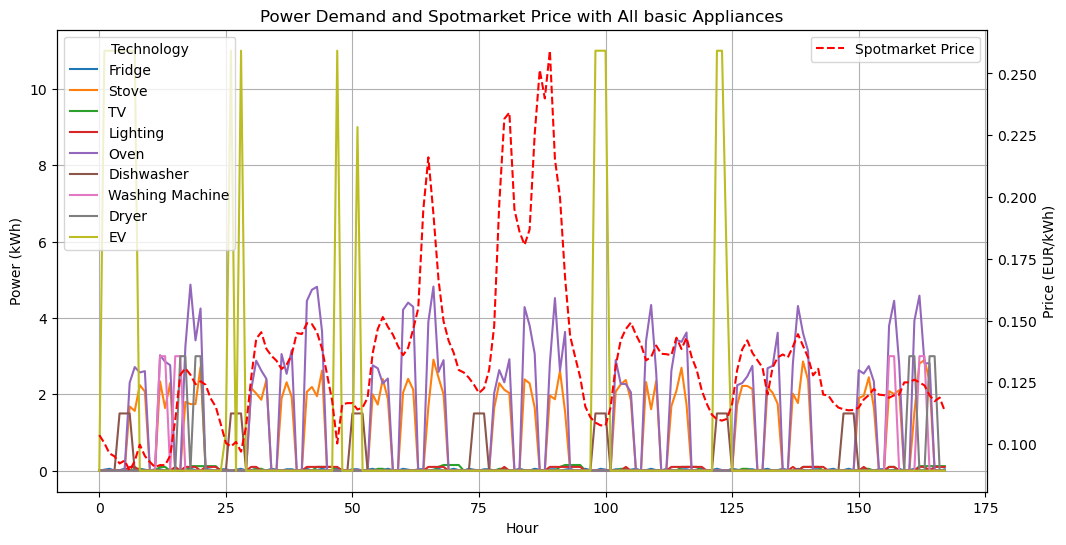

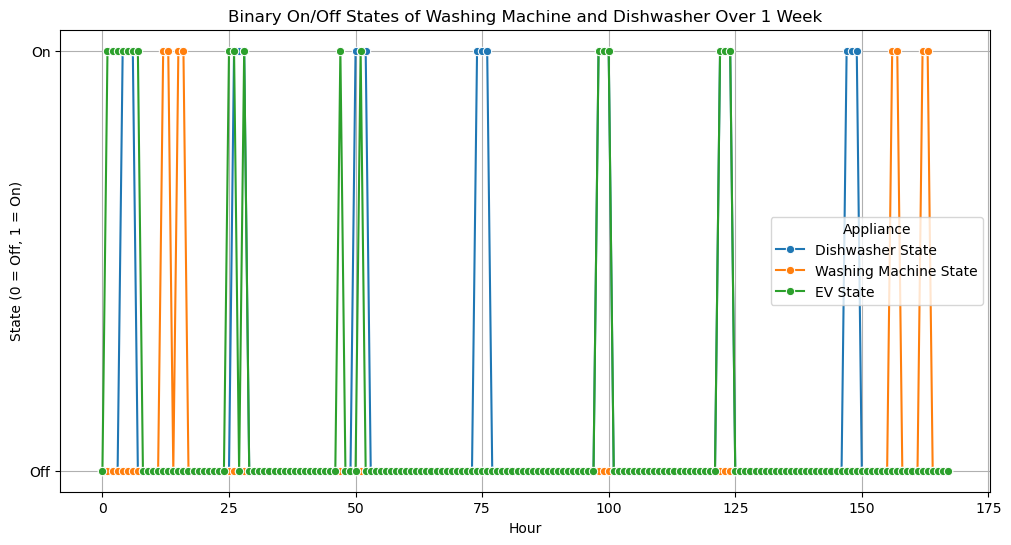

In [11]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Define the time range for one week
time_range = range(0, 24 * 7)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Fridge': fridge[:len(time_range)],
    'Stove': stove[:len(time_range)],
    'TV': tv[:len(time_range)],
    'Lighting': lighting[:len(time_range)],
    'Oven': oven[:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range],
    'Dryer': [power_dryer * binary_dryer[t].X for t in time_range],
    'EV': [charging_ev[t].X for t in time_range]
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')
total_power = data_power_melted.groupby('Hour')['Power (kWh)'].sum().reset_index()
# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
ax1 = plt.gca()

# Plot power demand (left y-axis)
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology', ax=ax1)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power (kWh)')
ax1.legend(title='Technology', loc='upper left')
ax1.grid(True)

# Create a second y-axis for the binary states
ax2 = ax1.twinx()
sns.lineplot(
    data=pd.DataFrame({'Hour': list(time_range), 'Price': merged_data_winter['Spotmarket_(EUR/kWh)'][:len(time_range)]}),
    x='Hour', y='Price', color='red', label='Spotmarket Price', linestyle='--', ax=ax2
)
ax2.set_ylabel('Price (EUR/kWh)')

plt.title('Power Demand and Spotmarket Price with All basic Appliances')
plt.show()

# Create a DataFrame for the second plot
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Dishwasher State': [binary_dishwasher[t].X for t in time_range],
    'Washing Machine State': [binary_wm[t].X for t in time_range],
    'EV State': [binary_ev[t].X for t in time_range]
})
# Melt the data for easier plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot 2: Binary on/off states of washing machine and dishwasher
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dishwasher Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()


### Summer